## Mimic EDA
#### Predicting and Understanding Unexpected Respiratory Decompensation in Critical Care Using Sparse and Heterogeneous Clinical Data

In [1]:
import numpy as np
import pandas as pd
import psycopg2
import os 
import random
import datetime
from sqlalchemy import create_engine
import mimic_utils as mimic
import magec_utils as mg
import matplotlib.pyplot as plt
from adjustText import adjust_text

pd.set_option('display.max_columns', None)

random.seed(22891)

%matplotlib inline

Using TensorFlow backend.


### MIMIC-III Data

In [2]:
# MIMIC-III
df = mimic.get_mimic_data()

### Get annotation data (if any) for patients in our cohort w/ advanced lung or heart disease

In [3]:
df_anno = pd.read_csv('physionet.org/files/phenotype-annotations-mimic/1.20.03/ACTdb102003.csv')
df_anno = df_anno[((df_anno['ADVANCED.LUNG.DISEASE'] == 1) | 
                  (df_anno['ADVANCED.HEART.DISEASE'] == 1)) & 
                  (df_anno['ADVANCED.CANCER'] == 0)]
users = list(set(df.subject_id.unique()).intersection(set(df_anno.SUBJECT_ID.unique())))
len(users)

47

In [4]:
np.save('case_users', users)

### MIMIC-III Data Engineering

In [5]:
vitals = ['heartrate_mean', 'sysbp_mean', 'diasbp_mean', 'meanbp_mean',
          'resprate_mean', 'tempc_mean', 'spo2_mean', 'glucose_mean']

labs = ['aniongap', 'albumin', 'bicarbonate', 'bilirubin', 'creatinine', 
        'chloride', 'glucose', 'hemoglobin', 'lactate', 
        'magnesium', 'phosphate', 'platelet', 'potassium', 'ptt', 'inr', 
        'pt', 'sodium', 'bun', 'wbc']  # -hematocrit

comobs = ['congestive_heart_failure', 'chronic_pulmonary', 'pulmonary_circulation']

others = ['age', 'gender']

features = vitals+labs

# Data featurized using 'last' measurements
df_ml = mimic.get_ml_data(df)

# Data featurized as time-series
df_time = mimic.get_ml_series_data(df)

_, x_validation, stsc, _, xst_validation, _, Y_validation = mimic.train_valid_ml(df_ml, 
                                                                                 include_valid='case_users.npy')

stsc2, series_means, _, df_series_valid, _, _, xt_valid, Yt_valid = mimic.train_valid_series(df_time, Y_validation)

In [6]:
series_means

gender                        0.562583
heartrate_mean               85.105305
bilirubin                     1.591420
resprate_mean                19.664887
ptt                          35.473116
aniongap                     16.297438
glucose                     160.903257
tempc_mean                   36.765522
sodium                      137.578144
pt                           16.078363
wbc                          12.167143
chronic_pulmonary             0.199298
platelet                    250.565683
potassium                     4.323906
magnesium                     1.947650
bun                          28.839523
meanbp_mean                  79.125184
pulmonary_circulation         0.064002
creatinine                    1.546555
albumin                       3.379839
spo2_mean                    96.682270
bicarbonate                  23.595292
glucose_mean                141.827799
hemoglobin                   11.875867
phosphate                     3.566423
chloride                 

### Load cohort data (demographics, vitals, labs and co-morbidities)

In [7]:
# information used to create a database connection
sqluser = 'postgres'
dbname = 'mimic'
engine = create_engine("postgresql+psycopg2://{}:{}@/{}".format(sqluser, sqluser, dbname))

conn = engine.connect()
schema_name = 'mimiciii'
conn.execute('SET search_path to ' + schema_name)

In [8]:
df_cohort = pd.read_sql("select * from mimic_users_study;", conn)

### Get notes for patients in our cohort

In [9]:
from mimic_queries import notes_query
df_notes = pd.read_sql(notes_query(prior_hours=48), conn)

### Get meds for patients in our cohort

In [10]:
from mimic_queries import meds_query
df_meds = pd.read_sql(meds_query(prior_hours=48), conn)

In [11]:
conn.close()

### Get MAgEC results for validation data (2128 patients)

In [12]:
joined = pd.read_csv('time_mimic_magecs_valid.csv')
joined['orig_prob_ensemble'] = joined[['orig_prob_mlp', 'orig_prob_lr', 
                                       'orig_prob_rf', 'orig_prob_lstm']].apply(np.mean, 1)

In [13]:
joined.case.nunique()

2128

### Cases with most potential

In [14]:
df_anno = pd.read_csv('physionet.org/files/phenotype-annotations-mimic/1.20.03/ACTdb102003.csv')

In [16]:
prob_cols = [c for c in joined.columns if c.startswith('perturb')]

In [17]:
joined[['best_feat', 'new_risk']] = joined.apply(lambda x: mimic.best_feature(x, prob_cols), axis=1)

In [18]:
predicate = (joined.orig_prob_ensemble > 0.5) & (joined.new_risk < 0.5)

my_cols = ['case', 'timepoint', 'orig_prob_ensemble', 'best_feat', 'new_risk']

joined[predicate][my_cols].sort_values('new_risk').head()

,case,timepoint,orig_prob_ensemble,best_feat,new_risk
10839,15044,12,0.549959,meanbp_mean,0.122119
13061,18250,5,0.556930,spo2_mean,0.123945
12515,17596,11,0.514156,meanbp_mean,0.126662
4058,5860,11,0.535313,resprate_mean,0.146461
4057,5860,12,0.506284,resprate_mean,0.153252


In [19]:
joined[predicate]['best_feat'].value_counts()

resprate_mean     984
lactate           368
meanbp_mean       365
bilirubin         155
heartrate_mean    148
ptt               111
glucose_mean       50
spo2_mean          46
diasbp_mean        44
albumin            30
aniongap           24
tempc_mean         22
phosphate          21
platelet           15
sysbp_mean         10
magnesium           7
bicarbonate         6
sodium              4
inr                 4
chloride            3
bun                 2
wbc                 1
creatinine          1
pt                  1
Name: best_feat, dtype: int64

In [20]:
joined[predicate][['best_feat', 'new_risk']].groupby('best_feat').mean().\
    sort_values('new_risk').head(10)

,new_risk
best_feat,
spo2_mean,0.392355
resprate_mean,0.406148
meanbp_mean,0.407277
sysbp_mean,0.407364
magnesium,0.410702
ptt,0.424390
diasbp_mean,0.427088
phosphate,0.427166
heartrate_mean,0.429840


### Is sysbp_mean ever identified by MAgEC w/ estimated risk below 0.5?

In [21]:
joined[predicate][joined[predicate]['best_feat'] == 'sysbp_mean'][my_cols].\
    sort_values('new_risk').head(10)

,case,timepoint,orig_prob_ensemble,best_feat,new_risk
14075,19845,15,0.526594,sysbp_mean,0.353429
22050,30591,11,0.502281,sysbp_mean,0.358490
22051,30591,10,0.517878,sysbp_mean,0.383553
16262,23121,16,0.586907,sysbp_mean,0.385466
16268,23121,7,0.510494,sysbp_mean,0.411352
14070,19845,21,0.500272,sysbp_mean,0.412268
16260,23121,18,0.557247,sysbp_mean,0.418320
16258,23121,20,0.560218,sysbp_mean,0.440637
14068,19845,24,0.565455,sysbp_mean,0.453739
24197,41251,9,0.528327,sysbp_mean,0.456383


### Time-series plot

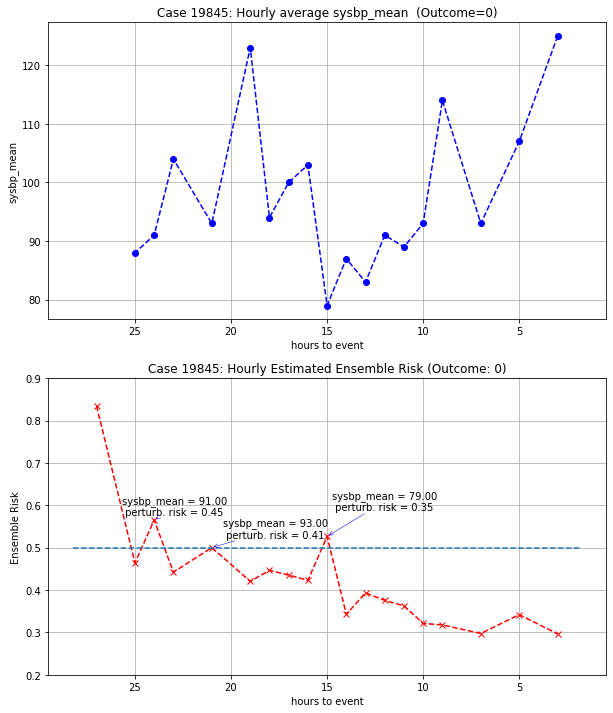

In [22]:
index = 14075
mimic.best_feat_plot(joined, df_cohort, index)

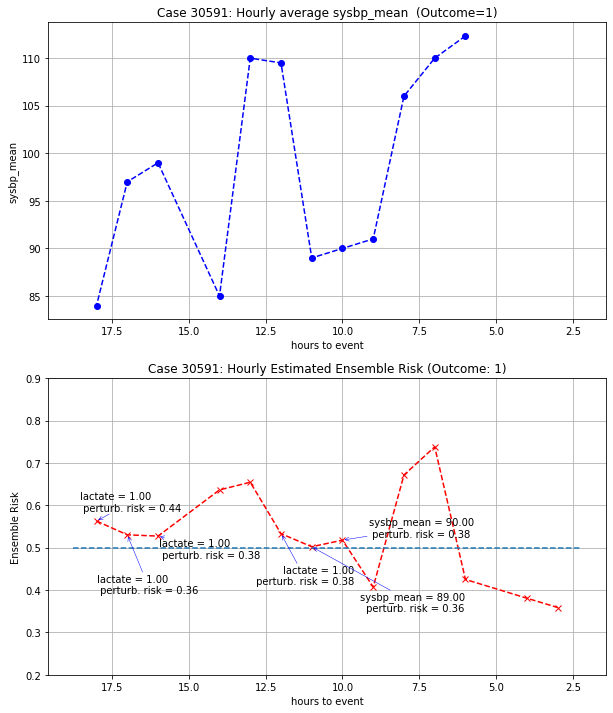

In [23]:
index = 22050
mimic.best_feat_plot(joined, df_cohort, index)

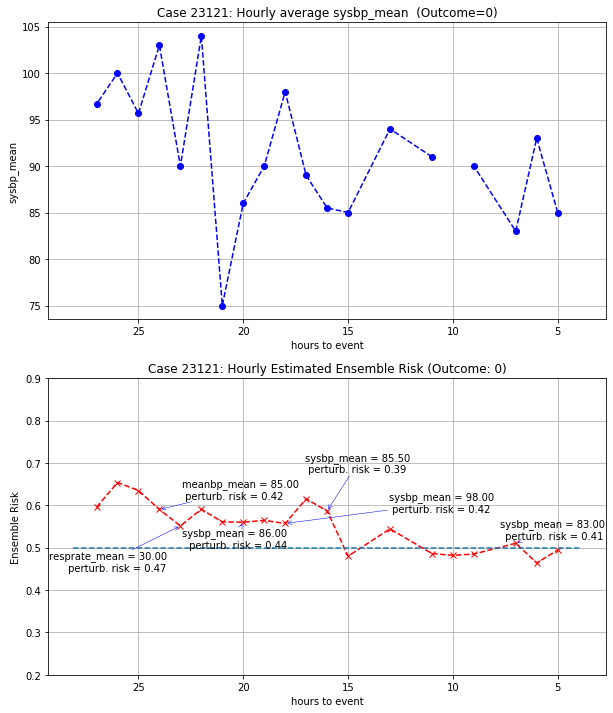

In [24]:
index = 16262
mimic.best_feat_plot(joined, df_cohort, index)

In [ ]:
index = 14075
case = 19845
mimic.feat_plot(joined, df_cohort, index)

In [ ]:
print_notes(case)

In [ ]:
cols = ['subject_id', 'timepoint', 'admittime', 'admission_type', 'los_icu',
        'diagnosis', 'curr_service', 'dischtime', 'mort_icu',
        'mv_start', 'mv_end', 'mv_hours', 'event_time',
        'age', 'gender', 'ethnicity']

data = df_cohort[(df_cohort.subject_id==case) & (df_cohort.timepoint==15)][cols]
data

In [ ]:
txt1 = (data.event_time - datetime.timedelta(hours=int(data.timepoint.values[0])) -
        data.admittime 
       ).iloc[0]

txt1 = (txt1.days)*24 + (txt1.seconds) // 3600

txt2 = (data.event_time - datetime.timedelta(hours=3) -
        data.admittime 
       ).iloc[0]

txt2 = (txt2.days)*24 + (txt2.seconds) // 3600

In [ ]:
txt1, txt2

In [ ]:
mg.panel_plot(xst_validation.columns, features, stsc2, joined, case, timepoint=int(data.timepoint.values[0]),
              models=('lr','rf','mlp','lstm'), label='label', limit=8, rotate=25, 
              save='case{}_t_{}'.format(case, int(data.timepoint.values[0])), 
              title='Case #{} {} hours after ICU admission'.format(case, txt1))

In [ ]:
mg.panel_plot(xst_validation.columns, features, stsc2, joined, case, timepoint=3,
              models=('lr','rf','mlp','lstm'), label='label', limit=8, rotate=25, 
              save='case{}_t_{}'.format(case, 3), 
              title='Case #{} {} hours after ICU admission'.format(case, txt2))

In [ ]:
set(df_meds[df_meds.subject_id==case]['drug_name_generic'].tolist())

### Find interesting patients for whom we have annotations

In [ ]:
cols = ['subject_id', 'timepoint', 'admittime', 'admission_type', 'los_icu',
        'diagnosis', 'curr_service', 'dischtime', 'mort_icu',
        'mv_start', 'mv_end', 'mv_hours',
        'age', 'gender', 'ethnicity']

valid_cases = df_cohort[np.isin(df_cohort.subject_id, users)].\
               sort_values(['subject_id', 'timepoint']).\
               groupby(['subject_id'])[cols].first()

In [ ]:
valid_cases[valid_cases['mv_hours'] > 0]

### Potential new cases

In [ ]:
# 6451, 19823
case = 29043
df_anno[df_anno.SUBJECT_ID==case].iloc[0]

In [ ]:
set(df_meds[df_meds.subject_id==case]['drug_name_generic'].tolist())

In [ ]:
t_min = df_cohort[df_cohort.subject_id==case]['timepoint'].min()
t_max = df_cohort[df_cohort.subject_id==case]['timepoint'].max()
print(t_min, t_max)

In [ ]:
timepoint = t_max
mg.panel_plot(xst_validation.columns, features, stsc2, joined, case, timepoint, 
              models=('lr','rf','mlp','lstm', 'ensemble'), label='label', limit=8, rotate=25)

In [ ]:
timepoint = t_min
mg.panel_plot(xst_validation.columns, features, stsc2, joined, case, timepoint, 
              models=('lr','rf','mlp','lstm', 'ensemble'), label='label', limit=8, rotate=25)